In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 데이터를 정리해보자

In [2]:
path = './data/Face Mask Dataset/'
dataset = {'image_path' : [], 'mask_status' : [], 'where' : []} # where 폴더이름

for where in os.listdir(path):
    for status in os.listdir(path + '/' + where):
        for image in glob.glob(path + where + '/' + status + '/' + '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)

In [3]:
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./data/Face Mask Dataset/Test/WithMask\1163.png,WithMask,Test
1,./data/Face Mask Dataset/Test/WithMask\1174.png,WithMask,Test
2,./data/Face Mask Dataset/Test/WithMask\1175.png,WithMask,Test
3,./data/Face Mask Dataset/Test/WithMask\1203.png,WithMask,Test
4,./data/Face Mask Dataset/Test/WithMask\1361.png,WithMask,Test


#### 간단한 EDA

With Mask : 5909
Without Mask : 5883


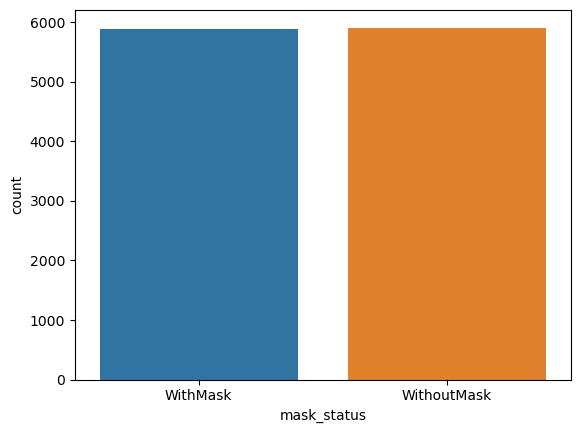

In [4]:
print('With Mask :',dataset.value_counts('mask_status')[0])
print('Without Mask :',dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status']);

#### 랜덤하게 어떤 그림이 있는지 확인하자

In [5]:
#!pip install opencv-python

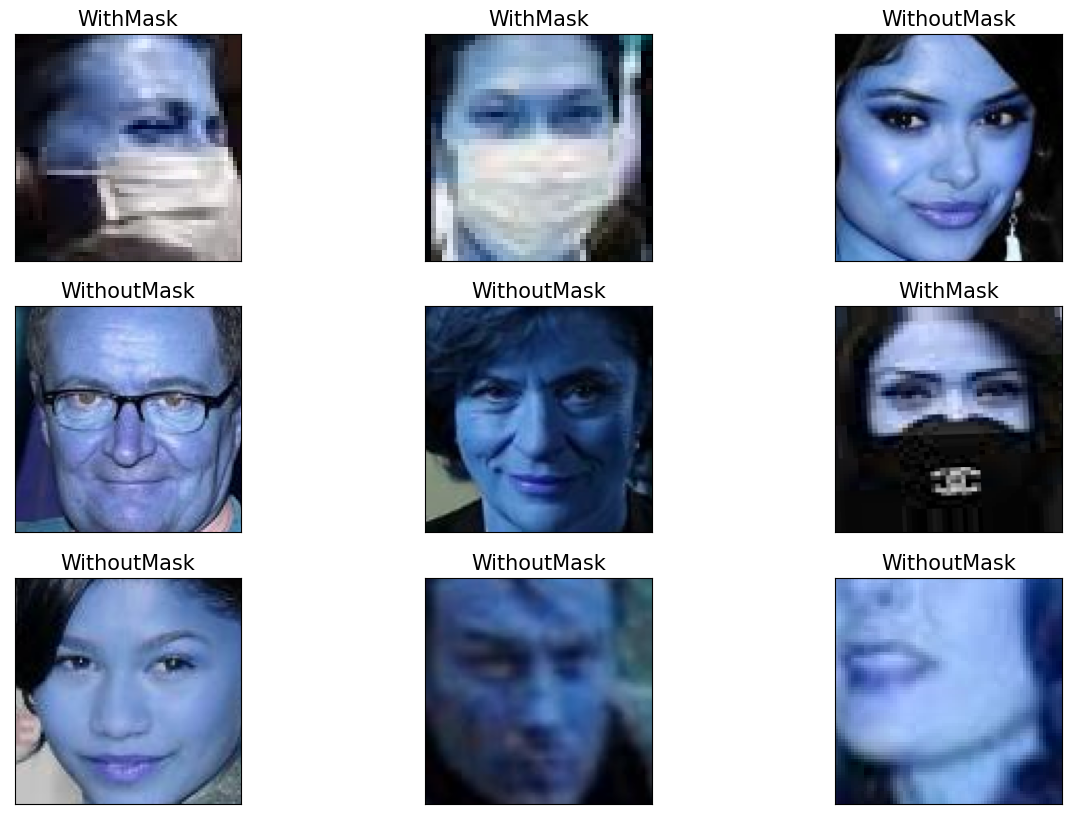

In [6]:
import cv2

plt.figure(figsize=(15,10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
    plt.title(dataset.loc[random, 'mask_status'], size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()

#### 데이터 분할

In [7]:
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
valid_df = dataset[dataset['where'] == 'Validation']

train_df.head()

,image_path,mask_status,where
992,./data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
993,./data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
994,./data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
995,./data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
996,./data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


##### 데이터 분포

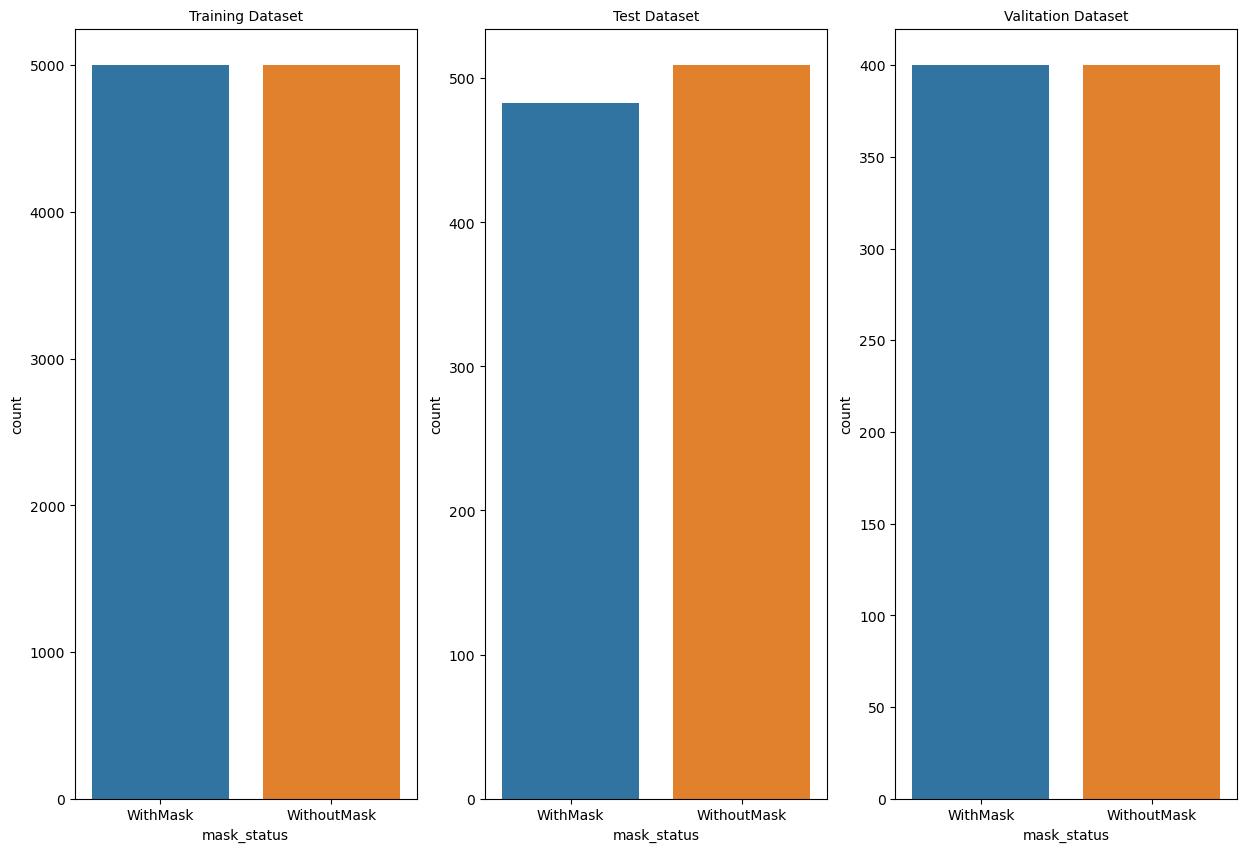

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
sns.countplot(x=train_df['mask_status'])
plt.title("Training Dataset", size=10)

plt.subplot(1,3,2)
sns.countplot(x=test_df['mask_status'])
plt.title("Test Dataset", size=10)

plt.subplot(1,3,3)
sns.countplot(x=valid_df['mask_status'])
plt.title("Valitation Dataset", size=10)

plt.show();

#### 인덱스 다시 정리

In [16]:
train_df = train_df.reset_index().drop("index", axis=1)
train_df.head()

,image_path,mask_status,where
0,./data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
1,./data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
2,./data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
3,./data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
4,./data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


#### 데이터 전처리

In [18]:
data = []
image_size = 150

for i in range(len(train_df)):
    # Converting the image into grayscale
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)
    
    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
    
    # Encoding the image with the label
    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [20]:
# 이미지 픽셀 값이들어있다. 맨 뒤에 1은 마스크, 0은 노마스크
data[0]

[array([[238, 238, 238, ..., 199, 199, 199],
        [238, 238, 238, ..., 197, 197, 197],
        [237, 237, 238, ..., 194, 194, 195],
        ...,
        [236, 236, 236, ..., 151, 151, 152],
        [235, 235, 235, ..., 151, 152, 152],
        [235, 235, 235, ..., 151, 152, 152]], dtype=uint8),
 1]

##### 데이터 섞기 (질서있게 있으면 학습에 이상하다...)

In [21]:
np.random.shuffle(data)

##### 데이터 회색화하여 출력

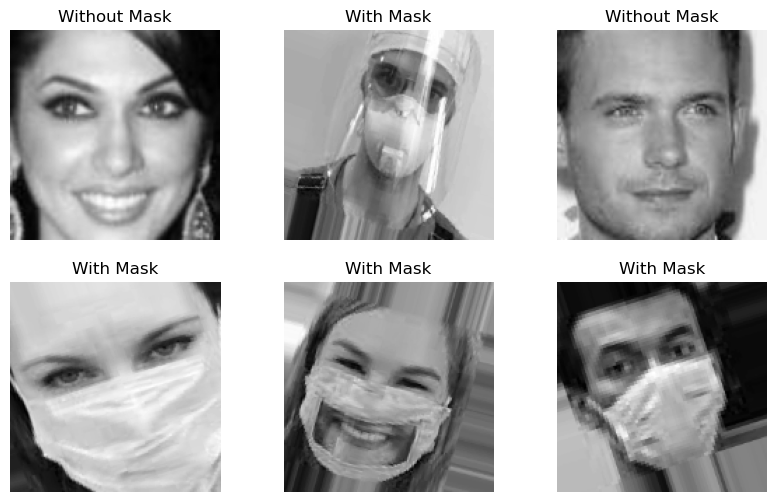

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col
        
        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap='gray')
        
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")

#### 하던데로 X, y 데이터를 나눠서 학습시켜보자

In [24]:
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [27]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                padding='same', activation='relu', input_shape=(150,150,1)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64,(2,2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [29]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 306s 1s/step - loss: 42.8699 - accuracy: 0.8869
Epoch 2/4
250/250 [==============================] - 334s 1s/step - loss: 0.0903 - accuracy: 0.9751
Epoch 3/4
250/250 [==============================] - 327s 1s/step - loss: 0.0367 - accuracy: 0.9879
Epoch 4/4
250/250 [==============================] - 343s 1s/step - loss: 0.0227 - accuracy: 0.9908


#### validation accuracy가 나쁘지 않다!

In [30]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 10s 137ms/step - loss: 0.1472 - accuracy: 0.9650


[0.14721110463142395, 0.9649999737739563]

##### 다른 성능 지수!

In [32]:
# 1로 예측한 것만 추출
prediction = (model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 9s 139ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       984
           1       0.98      0.95      0.97      1016

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.96      2000
weighted avg       0.97      0.96      0.97      2000

[[960  24]
 [ 46 970]]


##### 틀린 것을 봐보자

In [33]:
wrong_result = []

for n in range(0, len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)
    
len(wrong_result)

70

##### 틀린 이미지

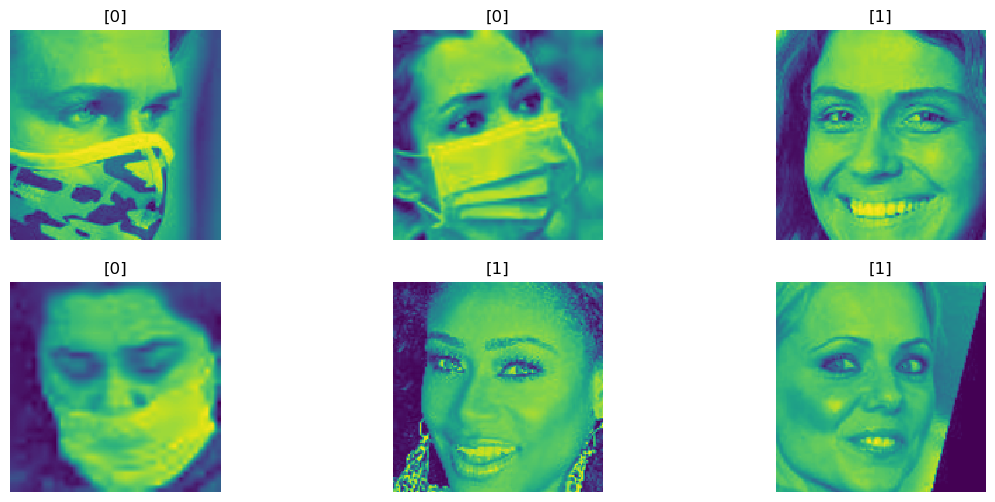

In [37]:
import random

samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14,6))

for idx, n in enumerate(samples):
    plt.subplot(2, 3, idx+1)
    plt.imshow(X_val[n].reshape(150, 150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')
    
plt.show()